In [13]:
import pymongo
import math 
# import re
import pandas as pd
import numpy as np
import pylab 
from matplotlib import pyplot as plt
# from scipy import stats 
from  qgrid import show_grid as show 
from datetime import datetime
from powerapi.formula import RAPLFormulaHWPCReportHandler, FormulaState
from powerapi.report import HWPCReport
import seaborn as sns
import re
import matplotlib as mpl 
%matplotlib inline
mpl.style.use('ggplot')



In [14]:
serveraddr = '172.16.45.8'
serverport=27017
db = pymongo.MongoClient(serveraddr, serverport)["variation"]
# x.to_csv("dockervsbin.csv",sep=";")
# alldata=pd.read_csv("dockervsbin.csv",sep=";")

In [15]:
def getRAPL(machinename):
    data=pd.DataFrame(list(db["rapl"+machinename].find({"target":"all"},projection={"timestamp":True,"groups.rapl":"True"})))
    data["cpu"]=data["groups"].apply(lambda row:math.ldexp(row["rapl"]["0"]["58"]["RAPL_ENERGY_PKG"],-32)+math.ldexp(row["rapl"]["1"]["13"]["RAPL_ENERGY_PKG"],-32))
    data=data.drop(["groups","_id"],axis=1)
    data.head()
    return data

def getTimes(filename):
    timesep= pd.read_csv("dockervsbinarry/"+filename,sep=";")
    timesep["timestamp"]=timesep["timestamp"].apply(lambda row :datetime.utcfromtimestamp(int(row)) )
    timesep=timesep.pivot(index="target",columns="state",values="timestamp")
    timesep["name"]=timesep.index
    timesep[["mode","benchmark","number"]]=timesep["name"].str.split("_",expand=True)
    timesep.drop("name",axis=1)
    timesep["number"]=timesep["number"].apply(lambda row:int(row))
    return timesep

def getEnergy(machinename,filename):
    timesep=getTimes(filename)
    raplep=getRAPL(machinename)
    energyep=timesep.apply(lambda row:raplep.loc[np.logical_and(raplep["timestamp"]>= row["begin"],raplep["timestamp"]<=row["end"]),["cpu"]].apply(np.trapz),axis=1)
    energyep["name"]=energyep.index
    energyep[["mode","benchmark","number"]]=energyep["name"].str.split("_",expand=True)
    energyep.drop("name",axis=1)
    energyep["number"]=timesep["number"].apply(int)
    return energyep
    

In [27]:
data=getEnergy("dockervisbiiin3","binvsdoc2log.csv")

In [12]:
x.to_csv("dockervsbinep30.csv")

In [46]:
show(data.groupby(["benchmark","mode"]).std())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [36]:
sampleSize=30
# energy2=cleanData( energy,groupobj="mode",measure="cpu")
energy2=data.loc[data["benchmark"]=="lu"]
dockers = energy2.loc[energy2["mode"]=="docker",["cpu"]]
binarries=energy2.loc[energy2["mode"]=="bin",["cpu"]]
meandocker=dockers["cpu"].mean()
meanbinarry=binarries["cpu"].mean()
np.random.seed=123444123
# print(meandocker)
# dockers["cpu"]=dockers.apply(lambda x: x["cpu"]-meandocker,axis=1)
# binarries["cpu"]=binarries.apply(lambda x : x["cpu"]-meanbinarry,axis=1)
btdocker=sns.algorithms.bootstrap(dockers,n_boot=1000,func=len,seed=12344123)
# btbinarry=sns.algorithms.bootstrap(binarries,n_boot=1000,func=np.std,seed=12344123)
btdocker= np.random.choice(dockers["cpu"], size=(5000, sampleSize))
btdocker=np.std(btdocker,1)
btbinarry=np.random.choice(binarries["cpu"], size=(5000, sampleSize))
btbinarry=np.std(btbinarry,1)

# print(np.std(binaries))
# print(np.std(dockers))
# show(energy2)
print("Docker: real value: {} , bt mean {}".format(np.std(dockers["cpu"]),np.mean(btdocker)))
print("binarry:real value: {} , bt mean {}".format(np.std(binarries["cpu"]),np.mean(btbinarry)))
xtics=x = np.linspace(0, 1, len(btdocker))

Docker: real value: 189.74172350987953 , bt mean 184.63129999739044
binarry:real value: 206.4898841889342 , bt mean 202.01537956660064


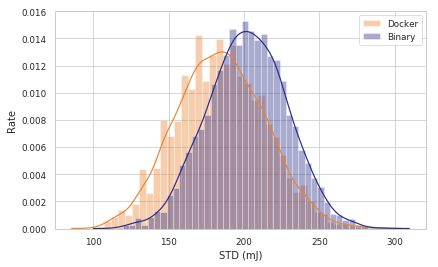

In [80]:
colors = ["#2A2D89","#d82e88", "#EB8533", "#75fb4c"]
palette=sns.color_palette(colors)
sns.set_style("whitegrid") 
# palette=sns.color_palette("Set2")
import matplotlib 
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['besries']
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10,"axes.tickarams.size":10})
fig, axes = plt.subplots(1,1, figsize=(6, 4))
plt.subplots_adjust(wspace=0.2,hspace = 0.1 ,left = 0.12,right = 0.98)
# data3=data2.loc[data2["Machine"]=="slpxDahu2"]
# data3["mode"]=data3["mode"].apply(lambda row:"Job" if row=="normal" else "Idle")

# fig=sns.boxplot(data=data3,x="energy",y="mode",palette=palette,ax=axes)

# fig.set_title("" )
# fig.tick_params(labelsize=8)
# fig.legend(loc=4,fontsize=15)

# fig = plt.figure(figsize=(10,6))
fig=sns.distplot(btdocker,label="Docker",color=palette[2])
fig= sns.distplot(btbinarry,label="Binary",color=palette[0])
fig.legend()
fig.set_xlabel(xlabel="STD (mJ)")
fig.set_ylabel(ylabel="Rate")
plt.savefig("docvsbin.pdf",format="pdf")

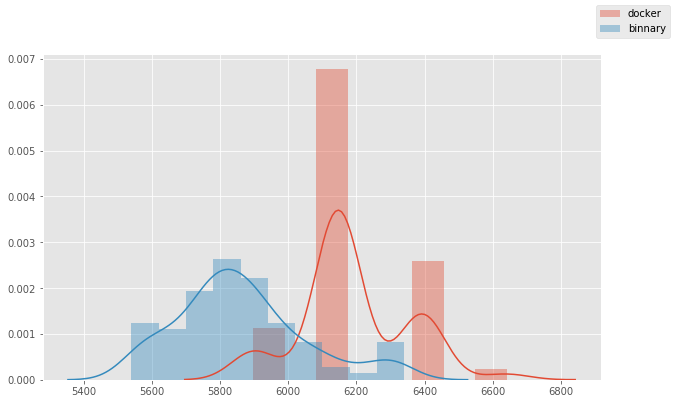

In [47]:
fig = plt.figure(figsize=(10,6))
sns.distplot(dockers,label="docker")
sns.distplot(binarries,label="binnary")
fig.legend(labels=['docker','binnary'])
plt.show()

In [48]:
data=pd.DataFrame()
data["val"]=btdocker
data["mode"]="docker"
data2=pd.DataFrame()
data2["val"]=btbinarry
data2["mode"]="binarry"

data=pd.concat([data,data2])
# show(data)

Text(0.5, 1.0, 'energy variation , docker vs binarry')

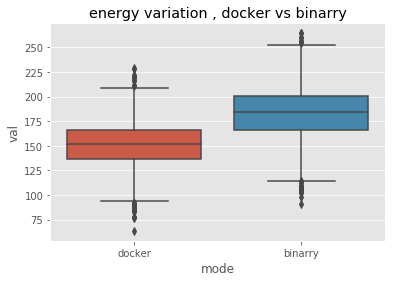

In [49]:
sns.boxplot(data=data,x="mode",y="val").set_title("energy variation , docker vs binarry")

In [ ]:
0664909870